In [29]:
import yfinance as yf
import pandas as pd
import os

In [30]:

sp500 = pd.read_excel('XMR-USDT_1min_start=2023-01-01 12/00/00_end=2023-12-01 12/00/00.xlsx', sheet_name='Sheet1')

In [31]:
TIME = 0
OPEN = 1
CLOSE = 2
HIGH= 3
LOW = 4
VOLUME = 5
TURNOVER = 6

#sp500.index = pd.to_datetime(sp500.index)

In [32]:
sp500
#Attention, plus vieux en indice 0

,0,1,2,3,4,5,6
0,2023-09-01 10:00:00,143.20,143.32,143.85,143.14,826.9735,118602.865169
1,2023-09-01 11:00:00,143.30,143.46,143.57,142.54,1546.0530,221238.874522
2,2023-09-01 12:00:00,143.46,143.81,144.30,143.24,2410.4382,346882.228203
3,2023-09-01 13:00:00,143.81,143.63,144.36,143.22,1217.5627,175235.657008
4,2023-09-01 14:00:00,143.58,141.97,143.58,141.76,2270.6293,323269.850379
...,...,...,...,...,...,...,...
2180,2023-12-01 06:00:00,170.74,170.30,170.74,169.81,1355.9082,230709.296190
2181,2023-12-01 07:00:00,170.29,170.22,170.72,170.01,1183.3101,201589.853136
2182,2023-12-01 08:00:00,170.19,170.13,170.98,170.03,2044.0059,348464.781207
2183,2023-12-01 09:00:00,170.19,171.16,171.19,170.16,1567.4019,267323.473954


<AxesSubplot:>

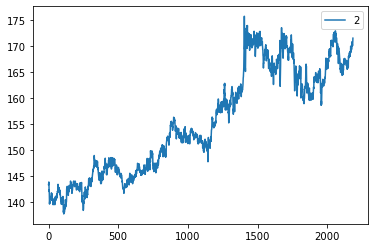

In [33]:
sp500.plot.line(y=CLOSE, use_index=True)

In [34]:
del sp500[TURNOVER]

In [35]:
sp500["Tomorrow"] = sp500[CLOSE].shift(-1)

In [36]:
sp500["Target"] = (sp500["Tomorrow"] > sp500[CLOSE]).astype(int)

In [37]:
#sp500 = sp500.loc["1990-01-01":].copy()

In [38]:
TIME = 0
OPEN = 1
CLOSE = 2
HIGH= 3
LOW = 4
VOLUME = 5
TURNOVER = 6

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = [CLOSE, VOLUME, OPEN, HIGH, LOW]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [39]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5142857142857142

<AxesSubplot:>

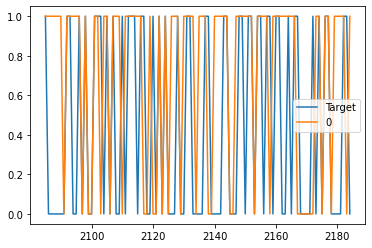

In [40]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [41]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [42]:
def backtest(data, model, predictors, start=1000, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [43]:
predictions = backtest(sp500, model, predictors)

In [44]:
predictions["Predictions"].value_counts()

1    639
0    546
Name: Predictions, dtype: int64

In [45]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5242566510172144

In [46]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.515612
0    0.484388
Name: Target, dtype: float64

In [47]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500[CLOSE] / rolling_averages[CLOSE]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [48]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [49]:
sp500

,0,1,2,3,4,5,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
1000,2023-10-13 02:00:00,151.66,151.22,151.66,150.91,1937.6331,151.48,1,0.998646,0.0,0.995117,1.0,0.991524,29.0,0.998779,122.0,1.035921,509.0
1001,2023-10-13 03:00:00,151.22,151.48,152.04,150.75,1638.4566,152.17,1,1.000859,1.0,0.998313,1.0,0.993393,29.0,1.000388,123.0,1.037645,509.0
1002,2023-10-13 04:00:00,151.51,152.17,152.34,151.51,979.9496,152.72,1,1.002272,2.0,1.003178,2.0,0.998013,29.0,1.004787,124.0,1.042312,509.0
1003,2023-10-13 05:00:00,152.20,152.72,152.72,152.20,285.9473,152.09,0,1.001804,2.0,1.005769,3.0,1.001616,30.0,1.008264,124.0,1.046014,510.0
1004,2023-10-13 06:00:00,152.72,152.09,152.96,152.09,936.7367,152.75,1,0.997933,1.0,1.001014,3.0,0.997595,29.0,1.003966,124.0,1.041627,510.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2180,2023-12-01 06:00:00,170.74,170.30,170.74,169.81,1355.9082,170.22,0,0.998827,0.0,0.998710,2.0,1.014836,27.0,1.019030,125.0,1.029964,519.0
2181,2023-12-01 07:00:00,170.29,170.22,170.72,170.01,1183.3101,170.13,0,0.999765,0.0,0.997925,2.0,1.014096,26.0,1.018387,124.0,1.029385,518.0
2182,2023-12-01 08:00:00,170.19,170.13,170.98,170.03,2044.0059,171.16,1,0.999736,0.0,0.998146,1.0,1.013249,26.0,1.017699,123.0,1.028743,518.0
2183,2023-12-01 09:00:00,170.19,171.16,171.19,170.16,1567.4019,171.56,1,1.003018,1.0,1.003859,1.0,1.018976,26.0,1.023659,124.0,1.034867,518.0


In [50]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [51]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [52]:
predictions = backtest(sp500, model, new_predictors)

In [53]:
predictions["Predictions"].value_counts()

0.0    153
1.0     32
Name: Predictions, dtype: int64

In [54]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6875

In [55]:
predictions["Target"].value_counts() / predictions.shape[0]

0    0.545946
1    0.454054
Name: Target, dtype: float64

In [56]:
predictions

,Target,Predictions
2000,0,0.0
2001,1,0.0
2002,0,0.0
2003,0,0.0
2004,0,0.0
...,...,...
2180,0,1.0
2181,0,0.0
2182,1,1.0
2183,1,0.0
